# 📊 Preprocesamiento de Datos - Delitos CDMX
## Preparación de Datos para Redes Neuronales

---

### Objetivos:
1. Cargar datos desde formato Parquet
2. Análisis de calidad de datos
3. Feature Engineering (características temporales, geográficas, categóricas)
4. Normalización y codificación
5. División de datasets (train/validation/test)
6. Guardar datos procesados para modelos de redes neuronales

**Autor**: Adonnay Bazaldua  
**Fecha**: Noviembre 2025

In [1]:
#!pip install imblearn

## 1. Importación de Librerías

In [2]:
# Procesamiento de datos
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# PySpark para grandes volúmenes
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *

# Scikit-learn para preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Configuración
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## 2. Inicialización de Spark Session

In [3]:
# Crear SparkSession optimizada
spark = (SparkSession.builder
         .appName("Neural_Networks_CDMX_Preprocessing")
         .master("local[4]")
         .config("spark.driver.memory", "6g")
         .config("spark.executor.memory", "6g")
         .config("spark.sql.shuffle.partitions", "8")
         .config("spark.sql.adaptive.enabled", "true")
         .getOrCreate())

spark.sparkContext.setLogLevel("WARN")

print(f"✅ Spark Session iniciada: {spark.version}")
print(f"   Cores disponibles: {spark.sparkContext.defaultParallelism}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/02 09:23:10 WARN Utils: Your hostname, kissabella, resolves to a loopback address: 127.0.1.1; using 192.168.1.87 instead (on interface wlo1)
25/12/02 09:23:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/02 09:23:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✅ Spark Session iniciada: 4.0.1
   Cores disponibles: 4


## 3. Carga de Datos desde Parquet

Los datos están particionados por año para optimizar las consultas.

In [4]:
# Ruta del dataset
parquet_path = "/home/adonnay_bazaldua/Documentos/GitHub/Crime-Analysis-in-Mexico-City-using-Neural-Networks/data/delitos_cdmx.parquet"

# Cargar datos
print("📂 Cargando datos desde Parquet...")
df_spark = spark.read.parquet(parquet_path)

# Información básica
print(f"\n📊 Dataset cargado:")
print(f"   Registros: {df_spark.count():,}")
print(f"   Columnas: {len(df_spark.columns)}")
print(f"   Particiones: {df_spark.rdd.getNumPartitions()}")

# Mostrar esquema
print("\n🔍 Esquema del dataset:")
df_spark.printSchema()

📂 Cargando datos desde Parquet...



📊 Dataset cargado:


   Registros: 2,098,743
   Columnas: 22
   Particiones: 4

🔍 Esquema del dataset:
root
 |-- anio_inicio: integer (nullable = true)
 |-- mes_inicio: string (nullable = true)
 |-- fecha_inicio: timestamp (nullable = true)
 |-- hora_inicio: string (nullable = true)
 |-- anio_hecho: double (nullable = true)
 |-- mes_hecho: string (nullable = true)
 |-- fecha_hecho: timestamp (nullable = true)
 |-- hora_hecho: string (nullable = true)
 |-- delito: string (nullable = true)
 |-- categoria_delito: string (nullable = true)
 |-- competencia: string (nullable = true)
 |-- fiscalia: string (nullable = true)
 |-- agencia: string (nullable = true)
 |-- unidad_investigacion: string (nullable = true)
 |-- colonia_hecho: string (nullable = true)
 |-- colonia_catalogo: string (nullable = true)
 |-- alcaldia_hecho: string (nullable = true)
 |-- alcaldia_catalogo: string (nullable = true)
 |-- municipio_hecho: string (nullable = true)
 |-- latitud: double (nullable = true)
 |-- longitud: double (nullable 

## 4. Análisis de Calidad de Datos

In [5]:
# Analizar valores nulos
print("🔎 Análisis de valores nulos:\n")

null_counts = df_spark.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c) 
    for c in df_spark.columns
]).collect()[0].asDict()

total_rows = df_spark.count()

null_df = pd.DataFrame([
    {
        'Columna': col,
        'Nulos': null_counts[col],
        'Porcentaje': (null_counts[col] / total_rows) * 100
    }
    for col in df_spark.columns
])

null_df = null_df.sort_values('Nulos', ascending=False)
null_df_filtered = null_df[null_df['Nulos'] > 0]

if len(null_df_filtered) > 0:
    print(null_df_filtered.to_string(index=False))
else:
    print("✅ No hay valores nulos en el dataset")

🔎 Análisis de valores nulos:



             Columna   Nulos  Porcentaje
   alcaldia_catalogo 2081157   99.162070
         competencia 1064018   50.697870
    colonia_catalogo  124440    5.929263
       colonia_hecho  102124    4.865960
            longitud  101207    4.822267
             latitud  101207    4.822267
unidad_investigacion     978    0.046599
          hora_hecho     887    0.042263
         fecha_hecho     560    0.026683
          anio_hecho     559    0.026635
           mes_hecho     559    0.026635
         hora_inicio      15    0.000715
        fecha_inicio       3    0.000143
           año_parte       3    0.000143
            fiscalia       2    0.000095


## 5. Conversión a Pandas para Feature Engineering

Convertimos el dataset completo filtrado de Spark a Pandas para poder realizar feature engineering.

In [6]:
print("📊 Convirtiendo dataset completo de Spark a Pandas...\n")

# Filtrar registros con coordenadas válidas
df_filtered = df_spark.filter(
    (F.col("latitud").isNotNull()) & 
    (F.col("longitud").isNotNull()) &
    (F.col("fecha_hecho").isNotNull())
)

print(f"   Registros con coordenadas válidas: {df_filtered.count():,}")

# Convertir a Pandas (dataset completo)
df = df_filtered.toPandas()

print(f"✅ Conversión completada: {len(df):,} registros")
print(f"\n📋 Información del DataFrame Pandas:")
print(df.info())

📊 Convirtiendo dataset completo de Spark a Pandas...



   Registros con coordenadas válidas: 1,997,102


PySparkValueError: [CANNOT_PARSE_DATATYPE] Unable to parse datatype. [Errno 111] Connection refused.

## 6. Feature Engineering

### 6.1 Features Temporales

In [ ]:
print("🕐 Creando features temporales...\n")


# Asegurar que fecha_hecho es datetime
df['fecha_hecho'] = pd.to_datetime(df['fecha_hecho'])

# Extraer componentes temporales
df['año'] = df['fecha_hecho'].dt.year
df['mes'] = df['fecha_hecho'].dt.month
df['dia'] = df['fecha_hecho'].dt.day
df['dia_semana'] = df['fecha_hecho'].dt.dayofweek  # 0=Lunes, 6=Domingo
df['trimestre'] = df['fecha_hecho'].dt.quarter
df['semana_año'] = df['fecha_hecho'].dt.isocalendar().week

# Características cíclicas (importante para redes neuronales)
df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)
df['dia_semana_sin'] = np.sin(2 * np.pi * df['dia_semana'] / 7)
df['dia_semana_cos'] = np.cos(2 * np.pi * df['dia_semana'] / 7)

# Hora del día (si está disponible)
if 'hora_hecho' in df.columns and df['hora_hecho'].notna().any():
    # Extraer hora como número
    df['hora'] = pd.to_datetime(df['hora_hecho'], format='%H:%M:%S', errors='coerce').dt.hour
    df['hora_sin'] = np.sin(2 * np.pi * df['hora'] / 24)
    df['hora_cos'] = np.cos(2 * np.pi * df['hora'] / 24)
    
    # Categorizar por periodo del día
    df['periodo_dia'] = pd.cut(df['hora'], 
                                bins=[0, 6, 12, 18, 24], 
                                labels=['Madrugada', 'Mañana', 'Tarde', 'Noche'],
                                include_lowest=True)

# Es fin de semana?
df['es_fin_semana'] = (df['dia_semana'] >= 5).astype(int)

print("✅ Features temporales creadas:")
temporal_features = ['año', 'mes', 'dia', 'dia_semana', 'trimestre', 'semana_año',
                     'mes_sin', 'mes_cos', 'dia_semana_sin', 'dia_semana_cos',
                     'es_fin_semana']
if 'hora' in df.columns:
    temporal_features.extend(['hora', 'hora_sin', 'hora_cos', 'periodo_dia'])
    
print(f"   {temporal_features}")

### 6.2 Features Geográficas

In [ ]:
print("🗺️  Creando features geográficas...\n")

# Normalizar coordenadas (importante para modelos)
df['latitud_norm'] = (df['latitud'] - df['latitud'].mean()) / df['latitud'].std()
df['longitud_norm'] = (df['longitud'] - df['longitud'].mean()) / df['longitud'].std()

# Densidad delictiva por alcaldía
alcaldia_counts = df['alcaldia_hecho'].value_counts()
df['densidad_alcaldia'] = df['alcaldia_hecho'].map(alcaldia_counts)

# Normalizar densidad
df['densidad_alcaldia_norm'] = (df['densidad_alcaldia'] - df['densidad_alcaldia'].min()) / \
                                (df['densidad_alcaldia'].max() - df['densidad_alcaldia'].min())

# Grid espacial (para CNN)
# Dividir CDMX en grid de 50x50 celdas
lat_bins = 50
lon_bins = 50

df['lat_bin'] = pd.cut(df['latitud'], bins=lat_bins, labels=False)
df['lon_bin'] = pd.cut(df['longitud'], bins=lon_bins, labels=False)

print("✅ Features geográficas creadas:")
geo_features = ['latitud', 'longitud', 'latitud_norm', 'longitud_norm', 
                'densidad_alcaldia', 'densidad_alcaldia_norm', 'lat_bin', 'lon_bin']
print(f"   {geo_features}")

🗺️  Creando features geográficas...

✅ Features geográficas creadas:
   ['latitud', 'longitud', 'latitud_norm', 'longitud_norm', 'densidad_alcaldia', 'densidad_alcaldia_norm', 'lat_bin', 'lon_bin']


### 6.3 Codificación de Variables Categóricas

In [ ]:
print("🏷️  Codificando variables categóricas...\n")

# Variables categóricas principales
categorical_cols = ['delito', 'categoria_delito', 'alcaldia_hecho', 'fiscalia']

# Filtrar columnas que existen y tienen datos
categorical_cols = [col for col in categorical_cols if col in df.columns and df[col].notna().any()]

# Label Encoding (para modelos tree-based y como referencia)
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col].fillna('UNKNOWN'))
    label_encoders[col] = le
    print(f"   ✓ {col}: {len(le.classes_)} clases únicas")

# Para la variable objetivo (delito), guardar el encoder
target_encoder = label_encoders['delito']
num_classes = len(target_encoder.classes_)

print(f"\n📊 Total de clases de delitos: {num_classes}")
print(f"\n🎯 Top 10 delitos más frecuentes:")
print(df['delito'].value_counts().head(10))

🏷️  Codificando variables categóricas...

   ✓ delito: 337 clases únicas
   ✓ categoria_delito: 17 clases únicas
   ✓ alcaldia_hecho: 16 clases únicas
   ✓ fiscalia: 94 clases únicas

📊 Total de clases de delitos: 337

🎯 Top 10 delitos más frecuentes:
delito
VIOLENCIA FAMILIAR                                       51152
FRAUDE                                                   29889
AMENAZAS                                                 27154
ROBO DE OBJETOS                                          22457
ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA           17523
ROBO A NEGOCIO SIN VIOLENCIA                             15098
ROBO DE ACCESORIOS DE AUTO                               14801
ROBO DE OBJETOS DEL INTERIOR DE UN VEHICULO              11493
ROBO A CASA HABITACION SIN VIOLENCIA                      8249
ROBO DE VEHICULO DE SERVICIO PARTICULAR SIN VIOLENCIA     8107
Name: count, dtype: int64


## 7. Análisis de Distribución de Clases

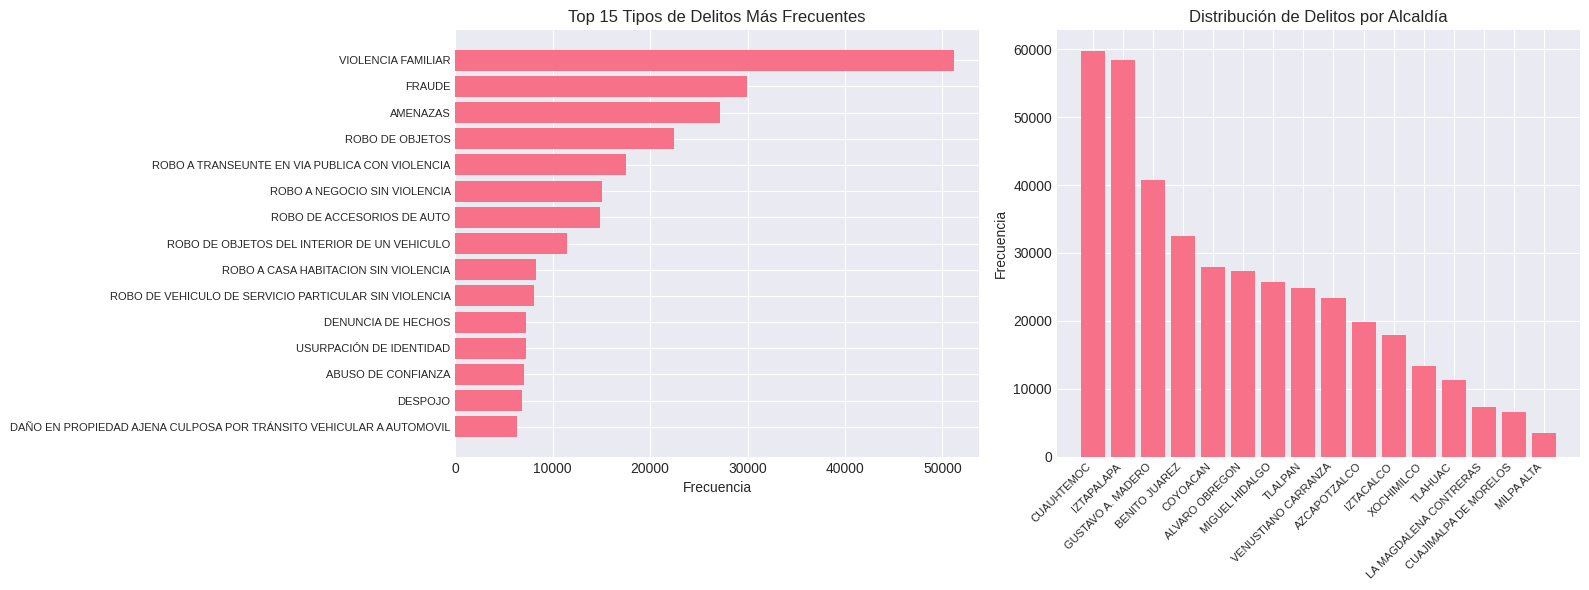


⚖️  Análisis de balance de clases:
   Clase más frecuente: VIOLENCIA FAMILIAR (51,152 casos)
   Clase menos frecuente: VIOLACION Y ROBO DE VEHICULO (1 casos)
   Ratio desbalance: 51152.00:1


In [ ]:
# Visualizar distribución de clases
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 delitos
top_delitos = df['delito'].value_counts().head(15)
axes[0].barh(range(len(top_delitos)), top_delitos.values)
axes[0].set_yticks(range(len(top_delitos)))
axes[0].set_yticklabels(top_delitos.index, fontsize=8)
axes[0].set_xlabel('Frecuencia')
axes[0].set_title('Top 15 Tipos de Delitos Más Frecuentes')
axes[0].invert_yaxis()

# Distribución por alcaldía
alcaldia_counts = df['alcaldia_hecho'].value_counts()
axes[1].bar(range(len(alcaldia_counts)), alcaldia_counts.values)
axes[1].set_xticks(range(len(alcaldia_counts)))
axes[1].set_xticklabels(alcaldia_counts.index, rotation=45, ha='right', fontsize=8)
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución de Delitos por Alcaldía')

plt.tight_layout()
plt.show()

# Estadísticas de balance
print("\n⚖️  Análisis de balance de clases:")
value_counts = df['delito'].value_counts()
print(f"   Clase más frecuente: {value_counts.index[0]} ({value_counts.iloc[0]:,} casos)")
print(f"   Clase menos frecuente: {value_counts.index[-1]} ({value_counts.iloc[-1]:,} casos)")
print(f"   Ratio desbalance: {value_counts.iloc[0] / value_counts.iloc[-1]:.2f}:1")

## 8. Selección de Features para Modelos

In [ ]:
print("🎯 Seleccionando features para modelos de redes neuronales...\n")

# Features numéricas para MLP
numerical_features = [
    # Temporales
    'año', 'mes', 'dia', 'dia_semana', 'trimestre', 'semana_año',
    'mes_sin', 'mes_cos', 'dia_semana_sin', 'dia_semana_cos',
    'es_fin_semana',
    # Geográficas
    'latitud_norm', 'longitud_norm', 'densidad_alcaldia_norm',
]

# Agregar hora si existe
if 'hora' in df.columns:
    numerical_features.extend(['hora', 'hora_sin', 'hora_cos'])

# Features categóricas codificadas
categorical_encoded = [f'{col}_encoded' for col in categorical_cols if col != 'delito']

# Todas las features para el modelo
all_features = numerical_features + categorical_encoded

# Variable objetivo
target = 'delito_encoded'

print(f"✅ Features seleccionadas: {len(all_features)}")
print(f"   - Numéricas: {len(numerical_features)}")
print(f"   - Categóricas codificadas: {len(categorical_encoded)}")
print(f"\n📋 Lista de features:")
for i, feat in enumerate(all_features, 1):
    print(f"   {i:2d}. {feat}")

🎯 Seleccionando features para modelos de redes neuronales...

✅ Features seleccionadas: 20
   - Numéricas: 17
   - Categóricas codificadas: 3

📋 Lista de features:
    1. año
    2. mes
    3. dia
    4. dia_semana
    5. trimestre
    6. semana_año
    7. mes_sin
    8. mes_cos
    9. dia_semana_sin
   10. dia_semana_cos
   11. es_fin_semana
   12. latitud_norm
   13. longitud_norm
   14. densidad_alcaldia_norm
   15. hora
   16. hora_sin
   17. hora_cos
   18. categoria_delito_encoded
   19. alcaldia_hecho_encoded
   20. fiscalia_encoded


## 9. División de Datos (Train/Validation/Test)

In [ ]:
print("✂️  Dividiendo datos en conjuntos de entrenamiento, validación y prueba...\n")

# Preparar X e y
X = df[all_features].copy()
y = df[target].copy()

# Eliminar posibles NaN
X = X.fillna(0)

# Primera división: 80% train+val, 20% test (SIN stratify)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Segunda división: 75% train, 25% validation (SIN stratify)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)

print(f"📊 División de datos:")
print(f"   Train:      {len(X_train):,} muestras ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Validation: {len(X_val):,} muestras ({len(X_val)/len(X)*100:.1f}%)")
print(f"   Test:       {len(X_test):,} muestras ({len(X_test)/len(X)*100:.1f}%)")
print(f"\n   Total: {len(X):,} muestras")
print(f"   Features: {X.shape[1]}")
print(f"   Clases: {num_classes}")

## 10. Normalización de Features

Importante para redes neuronales: todas las features deben estar en la misma escala.

In [ ]:
print("📏 Normalizando features con StandardScaler...\n")

# Crear escalador
scaler = StandardScaler()

# Ajustar solo con datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convertir a DataFrames para mantener nombres de columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✅ Normalización completada")
print(f"\n📊 Estadísticas del conjunto de entrenamiento normalizado:")
print(X_train_scaled.describe())

📏 Normalizando features con StandardScaler...



NameError: name 'X_train' is not defined

## 11. Guardar Datos Procesados

In [ ]:
import pickle
import os

# Crear directorio para datos procesados
os.makedirs('processed_data', exist_ok=True)

print("💾 Guardando datos procesados...\n")

# Guardar conjuntos de datos
np.save('processed_data/X_train.npy', X_train_scaled.values)
np.save('processed_data/X_val.npy', X_val_scaled.values)
np.save('processed_data/X_test.npy', X_test_scaled.values)
np.save('processed_data/y_train.npy', y_train.values)
np.save('processed_data/y_val.npy', y_val.values)
np.save('processed_data/y_test.npy', y_test.values)

# Guardar scaler y encoders
with open('processed_data/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('processed_data/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

with open('processed_data/target_encoder.pkl', 'wb') as f:
    pickle.dump(target_encoder, f)

# Guardar nombres de features
with open('processed_data/feature_names.pkl', 'wb') as f:
    pickle.dump(all_features, f)

# Guardar metadata
metadata = {
    'num_classes': num_classes,
    'num_features': len(all_features),
    'train_samples': len(X_train),
    'val_samples': len(X_val),
    'test_samples': len(X_test),
    'feature_names': all_features,
    'class_names': target_encoder.classes_.tolist()
}

with open('processed_data/metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print("✅ Datos guardados en 'processed_data/':")
print("   - X_train.npy, X_val.npy, X_test.npy")
print("   - y_train.npy, y_val.npy, y_test.npy")
print("   - scaler.pkl")
print("   - label_encoders.pkl")
print("   - target_encoder.pkl")
print("   - feature_names.pkl")
print("   - metadata.pkl")

print(f"\n📦 Tamaño total de archivos procesados:")
total_size = sum(os.path.getsize(f'processed_data/{f}') 
                 for f in os.listdir('processed_data/')) / (1024**2)
print(f"   {total_size:.2f} MB")

## 12. Preparación de Datos para Series Temporales (LSTM/GRU)

Para modelos recurrentes, necesitamos organizar los datos como secuencias temporales.

In [ ]:
print("📈 Preparando datos para series temporales...\n")

# Agregar datos por día y tipo de delito
df_timeseries = df.copy()
df_timeseries['fecha'] = df_timeseries['fecha_hecho'].dt.date

# Contar delitos por día y categoría
delitos_por_dia = df_timeseries.groupby(['fecha', 'categoria_delito']).size().reset_index(name='count')

# Pivotear para tener una columna por categoría de delito
delitos_pivot = delitos_por_dia.pivot(index='fecha', columns='categoria_delito', values='count').fillna(0)

# Agregar total de delitos por día
delitos_pivot['total_delitos'] = delitos_pivot.sum(axis=1)

# Resetear índice
delitos_pivot = delitos_pivot.reset_index()
delitos_pivot['fecha'] = pd.to_datetime(delitos_pivot['fecha'])
delitos_pivot = delitos_pivot.sort_values('fecha')

print(f"✅ Serie temporal creada:")
print(f"   Fechas: {delitos_pivot['fecha'].min()} a {delitos_pivot['fecha'].max()}")
print(f"   Días: {len(delitos_pivot)}")
print(f"   Categorías de delitos: {len(delitos_pivot.columns) - 2}")

# Guardar datos de series temporales
delitos_pivot.to_csv('processed_data/timeseries_data.csv', index=False)
print("\n💾 Guardado en 'processed_data/timeseries_data.csv'")

# Visualización rápida
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(delitos_pivot['fecha'], delitos_pivot['total_delitos'], linewidth=1)
ax.set_xlabel('Fecha')
ax.set_ylabel('Total de Delitos por Día')
ax.set_title('Serie Temporal de Delitos en CDMX')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 13. Preparación de Grid Espacial para CNN

In [ ]:
print("🗺️  Creando grid espacial para CNN...\n")

# Crear matriz 2D de densidad delictiva
grid_size = 50

# Crear histograma 2D
heatmap, xedges, yedges = np.histogram2d(
    df['latitud'], 
    df['longitud'],
    bins=grid_size
)

print(f"✅ Grid espacial creado: {heatmap.shape}")
print(f"   Rango latitud: {xedges[0]:.4f} a {xedges[-1]:.4f}")
print(f"   Rango longitud: {yedges[0]:.4f} a {yedges[-1]:.4f}")
print(f"   Total delitos en grid: {heatmap.sum():.0f}")

# Guardar grid
np.save('processed_data/spatial_grid.npy', heatmap)
np.save('processed_data/spatial_edges.npy', {'lat': xedges, 'lon': yedges})

# Visualización
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(heatmap.T, origin='lower', cmap='hot', interpolation='bilinear')
ax.set_title('Mapa de Calor de Delitos en CDMX (Grid 50x50)', fontsize=14, fontweight='bold')
ax.set_xlabel('Latitud (bins)')
ax.set_ylabel('Longitud (bins)')
plt.colorbar(im, ax=ax, label='Número de Delitos')
plt.tight_layout()
plt.show()

print("\n💾 Guardado en 'processed_data/spatial_grid.npy'")

## 14. Resumen del Preprocesamiento

In [ ]:
print("="*80)
print(" "*25 + "RESUMEN DEL PREPROCESAMIENTO")
print("="*80)

print(f"\n📊 DATOS ORIGINALES:")
print(f"   Registros totales: {total_rows:,}")
print(f"   Muestra utilizada: {len(df):,} ({sample_fraction*100}%)")
print(f"   Columnas originales: {len(df_spark.columns)}")

print(f"\n🔧 FEATURES CREADAS:")
print(f"   Features temporales: {len([f for f in all_features if any(t in f for t in ['año', 'mes', 'dia', 'hora', 'semana', 'trimestre', 'sin', 'cos'])])}")
print(f"   Features geográficas: {len([f for f in all_features if any(g in f for g in ['latitud', 'longitud', 'densidad'])])}")
print(f"   Features categóricas: {len(categorical_encoded)}")
print(f"   Total features: {len(all_features)}")

print(f"\n✂️ DIVISIÓN DE DATOS:")
print(f"   Entrenamiento: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Validación: {len(X_val):,} ({len(X_val)/len(X)*100:.1f}%)")
print(f"   Prueba: {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")

print(f"\n🎯 VARIABLE OBJETIVO:")
print(f"   Número de clases: {num_classes}")
print(f"   Clase más frecuente: {df['delito'].value_counts().index[0]}")
print(f"   Frecuencia: {df['delito'].value_counts().iloc[0]:,}")

print(f"\n💾 ARCHIVOS GUARDADOS:")
print(f"   ✓ Conjuntos train/val/test (NumPy)")
print(f"   ✓ Scaler y encoders (pickle)")
print(f"   ✓ Metadata del proyecto")
print(f"   ✓ Datos de series temporales (CSV)")
print(f"   ✓ Grid espacial para CNN (NumPy)")

print(f"\n✅ PREPROCESAMIENTO COMPLETADO")
print(f"   Los datos están listos para entrenar redes neuronales")
print("\n" + "="*80)

## 15. Próximos Pasos

Con los datos preprocesados y guardados, podemos proceder a:

1. **MLP Classification** (`02_MLP_Classification.ipynb`): Red neuronal feedforward para clasificación multi-clase
2. **LSTM Time Series** (`03_LSTM_TimeSeries.ipynb`): Predicción de tendencias temporales
3. **GRU Time Series** (`04_GRU_TimeSeries.ipynb`): Comparación con LSTM
4. **CNN Spatial** (`05_CNN_Spatial.ipynb`): Análisis de patrones espaciales
5. **Autoencoder** (`06_Autoencoder_Anomalies.ipynb`): Detección de anomalías

---

**Autor**: Adonnay Bazaldua  
**Proyecto**: Análisis de Delitos CDMX con Redes Neuronales

In [ ]:
# Detener Spark Session
spark.stop()
print("🛑 Spark Session detenida")